In [1]:
%load_ext autoreload
%autoreload 2

# Analyse the traffic information in screenshots from Google maps

In [2]:
import cv2
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import pandas as pd
import re
from pprint import pprint
from traffic_analysis import (
    display_shot,
    load_config,
    maximum_measure_points,
    get_colors_from_screenshots,
    show_points_on_screenshot,
)

In [3]:
# Which street to analyse and in what direction
LOCATION = "leuven"
STREET = "tiensestraat"
POINTS_LIST_NAME = "blijdeinkomstraat_from" # must be "to" the crossing or away "from" the crossing

In [4]:
def check_keys_exist(config: dict, location:str, street:str, point:str) -> bool:
    # Check if 'location' key exists in 'config'
    if location in config.keys():
        # Check if 'street' key exists under 'location'
        if street in config[location].keys():
            # Check if 'point' key exists under 'street'
            if point in config[location][street]["points"].keys():
                return True
    # If any of the checks fail
    return False

In [5]:
config[LOCATION][STREET]["points"].keys()

UsageError: Invalid config statement: '[LOCATION][STREET]["points"].keys()', should be `Class.trait = value`.


In [6]:
# Directory where the screenshots are stored
URL_IMAGE_DIR = "shots"
url_image_dir = Path(URL_IMAGE_DIR)
assert url_image_dir.exists()

# config file in TOML format that contains the URL's for the screenshots
CONFIG_FILE = "config.toml"
assert Path(CONFIG_FILE).exists()

In [7]:
# Get the URL of the first image on the LOCATION and STREET

url_image = next(url_image_dir.glob(f"{LOCATION}_{STREET}_*.png"))
assert url_image.exists()
url_image

PosixPath('shots/leuven_tiensestraat_20231017-180213.png')

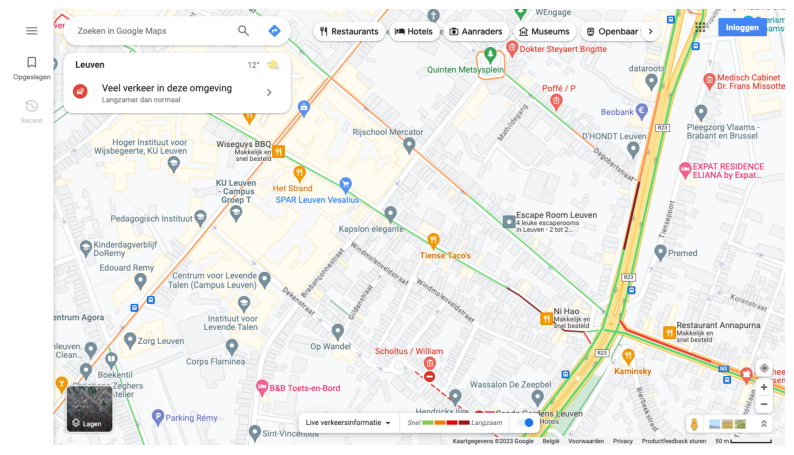

In [8]:
ax = display_shot(url_image)
plt.show()

In [9]:
config = load_config(CONFIG_FILE)

# Print the values
pprint(config[LOCATION][STREET])

{'points': {'blijdeinkomstraat_from': [[980, 499],
                                       [957, 479],
                                       [936, 461],
                                       [907, 437],
                                       [880, 414],
                                       [868, 403],
                                       [804, 348],
                                       [767, 316],
                                       [733, 288],
                                       [708, 267],
                                       [691, 251],
                                       [670, 233],
                                       [645, 213],
                                       [623, 193],
                                       [596, 171],
                                       [543, 125],
                                       [518, 104],
                                       [464, 53]],
            'to': [[946, 532],
                   [916, 531],
                   [

In [11]:
assert check_keys_exist(
    config, LOCATION, STREET, POINTS_LIST_NAME
), f"Could not find list of point config['{LOCATION}']['{STREET}']['points']['{POINTS_LIST_NAME}']. Please add to {CONFIG_FILE}"

In [12]:
streets = list(config[LOCATION].keys())
streets

['geldenaaksevest', 'tiensevest', 'tiensesteenweg', 'tiensestraat']

In [13]:
assert (
    POINTS_LIST_NAME in config[LOCATION][STREET]["points"].keys()
), f"Found no points to sample from, add [[x0, y0], ..., [xn, yn]] in key {POINTS_LIST_NAME} in {LOCATION}.{STREET}"

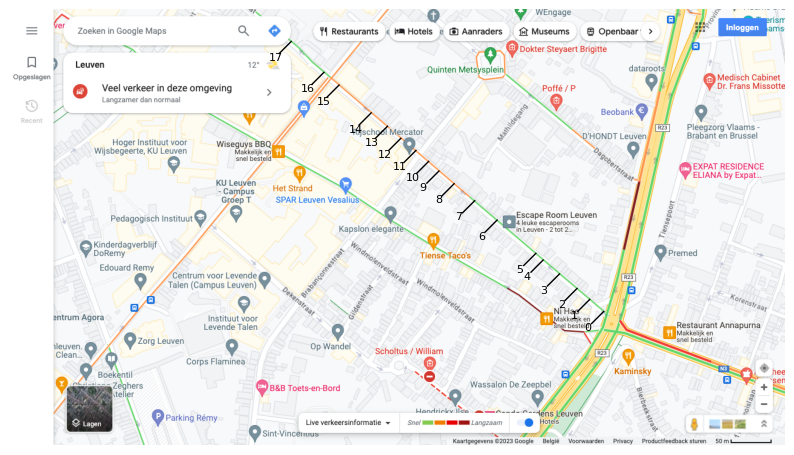

In [14]:
# Plot the points where to measure traffic flow

ax = show_points_on_screenshot(
    config,
    LOCATION,
    STREET,
    url_image,
    points_list_name=POINTS_LIST_NAME,
    x_text_offset=6,
    x_line_offset=20,
)

plt.savefig(
    f"figs/meetpunten_{LOCATION}_{STREET}_{POINTS_LIST_NAME}.png",  # Set path and filename
    dpi=300,  # Set dots per inch
    bbox_inches="tight",  # Remove extra whitespace around plot
    facecolor="white",
)
plt.show()

In [15]:
number_of_points = len(config[LOCATION][STREET]["points"][POINTS_LIST_NAME])
print(f"The number of points to measure is")
print(f"{number_of_points=} in {LOCATION=} {STREET=} {POINTS_LIST_NAME=}")

The number of points to measure is
number_of_points=18 in LOCATION='leuven' STREET='tiensestraat' POINTS_LIST_NAME='blijdeinkomstraat_from'


# Walk over screenshots and sample pixel colors

In [16]:
config[LOCATION][STREET]["points"][POINTS_LIST_NAME]

[[980, 499],
 [957, 479],
 [936, 461],
 [907, 437],
 [880, 414],
 [868, 403],
 [804, 348],
 [767, 316],
 [733, 288],
 [708, 267],
 [691, 251],
 [670, 233],
 [645, 213],
 [623, 193],
 [596, 171],
 [543, 125],
 [518, 104],
 [464, 53]]

In [17]:
number_of_points, _, _, _ = maximum_measure_points(config)
number_of_points

34

In [18]:
df = get_colors_from_screenshots(
    config, url_image_dir, location=LOCATION, street=STREET, points_list_name=POINTS_LIST_NAME
)

df.head()

,location,street,path,timestamp,color_0,p0_red,p0_green,p0_blue,traffic_color_0,color_1,...,color_32,p32_red,p32_green,p32_blue,traffic_color_32,color_33,p33_red,p33_green,p33_blue,traffic_color_33
18,leuven,tiensestraat,shots/leuven_tiensestraat_20231017-114239.png,2023-10-17 11:42:39,"[86, 184, 104]",86,184,104,grey,"[99, 214, 104]",...,"[128, 128, 128]",128,128,128,grey,"[128, 128, 128]",128,128,128,grey
22,leuven,tiensestraat,shots/leuven_tiensestraat_20231017-114543.png,2023-10-17 11:45:43,"[86, 184, 104]",86,184,104,grey,"[99, 214, 104]",...,"[128, 128, 128]",128,128,128,grey,"[128, 128, 128]",128,128,128,grey
11,leuven,tiensestraat,shots/leuven_tiensestraat_20231017-115054.png,2023-10-17 11:50:54,"[86, 184, 104]",86,184,104,grey,"[99, 214, 104]",...,"[128, 128, 128]",128,128,128,grey,"[128, 128, 128]",128,128,128,grey
32,leuven,tiensestraat,shots/leuven_tiensestraat_20231017-115605.png,2023-10-17 11:56:05,"[86, 184, 104]",86,184,104,grey,"[99, 214, 104]",...,"[128, 128, 128]",128,128,128,grey,"[128, 128, 128]",128,128,128,grey
7,leuven,tiensestraat,shots/leuven_tiensestraat_20231017-120116.png,2023-10-17 12:01:16,"[86, 184, 104]",86,184,104,grey,"[99, 214, 104]",...,"[128, 128, 128]",128,128,128,grey,"[128, 128, 128]",128,128,128,grey


In [19]:
df.tail()

,location,street,path,timestamp,color_0,p0_red,p0_green,p0_blue,traffic_color_0,color_1,...,color_32,p32_red,p32_green,p32_blue,traffic_color_32,color_33,p33_red,p33_green,p33_blue,traffic_color_33
16,leuven,tiensestraat,shots/leuven_tiensestraat_20231017-174640.png,2023-10-17 17:46:40,"[86, 184, 104]",86,184,104,grey,"[99, 214, 104]",...,"[128, 128, 128]",128,128,128,grey,"[128, 128, 128]",128,128,128,grey
21,leuven,tiensestraat,shots/leuven_tiensestraat_20231017-175151.png,2023-10-17 17:51:51,"[86, 184, 104]",86,184,104,grey,"[99, 214, 104]",...,"[128, 128, 128]",128,128,128,grey,"[128, 128, 128]",128,128,128,grey
3,leuven,tiensestraat,shots/leuven_tiensestraat_20231017-175702.png,2023-10-17 17:57:02,"[86, 184, 104]",86,184,104,grey,"[99, 214, 104]",...,"[128, 128, 128]",128,128,128,grey,"[128, 128, 128]",128,128,128,grey
0,leuven,tiensestraat,shots/leuven_tiensestraat_20231017-180213.png,2023-10-17 18:02:13,"[86, 184, 104]",86,184,104,grey,"[99, 214, 104]",...,"[128, 128, 128]",128,128,128,grey,"[128, 128, 128]",128,128,128,grey
27,leuven,tiensestraat,shots/leuven_tiensestraat_20231017-180725.png,2023-10-17 18:07:25,"[86, 184, 104]",86,184,104,grey,"[99, 214, 104]",...,"[128, 128, 128]",128,128,128,grey,"[128, 128, 128]",128,128,128,grey


## Inspect the dataframe

In [20]:
df["street"].value_counts()

street
tiensestraat    39
Name: count, dtype: int64

## Display all colors that are found in the dataframe

In [21]:
# Create a set with all unique colors in the color columns
unique_colors = {color for column in  df.filter(regex='^color_').columns for color in df[column].astype(str).unique()}
print(f"There are {len(unique_colors)} in found")
print("All unique colors:")
print(", ".join(unique_colors))

There are 15 in found
All unique colors:
[216 132  82], [ 99 214 104], [255 151  77], [255 153  81], [107 216 112], [128, 128, 128], [255 156  86], [112 217 117], [ 86 184 104], [242  60  50], [113 218 118], [108 216 113], [255 157  87], [255 153  80], [116 219 121]


In [22]:
# Create a grid of colors
number_of_colors = len(unique_colors)
mosaic = [[f"color_{3*i}", f"color_{3*i+1}", f"color_{3*i+2}"] for i in range(1+number_of_colors//3)]
mosaic

[['color_0', 'color_1', 'color_2'],
 ['color_3', 'color_4', 'color_5'],
 ['color_6', 'color_7', 'color_8'],
 ['color_9', 'color_10', 'color_11'],
 ['color_12', 'color_13', 'color_14'],
 ['color_15', 'color_16', 'color_17']]

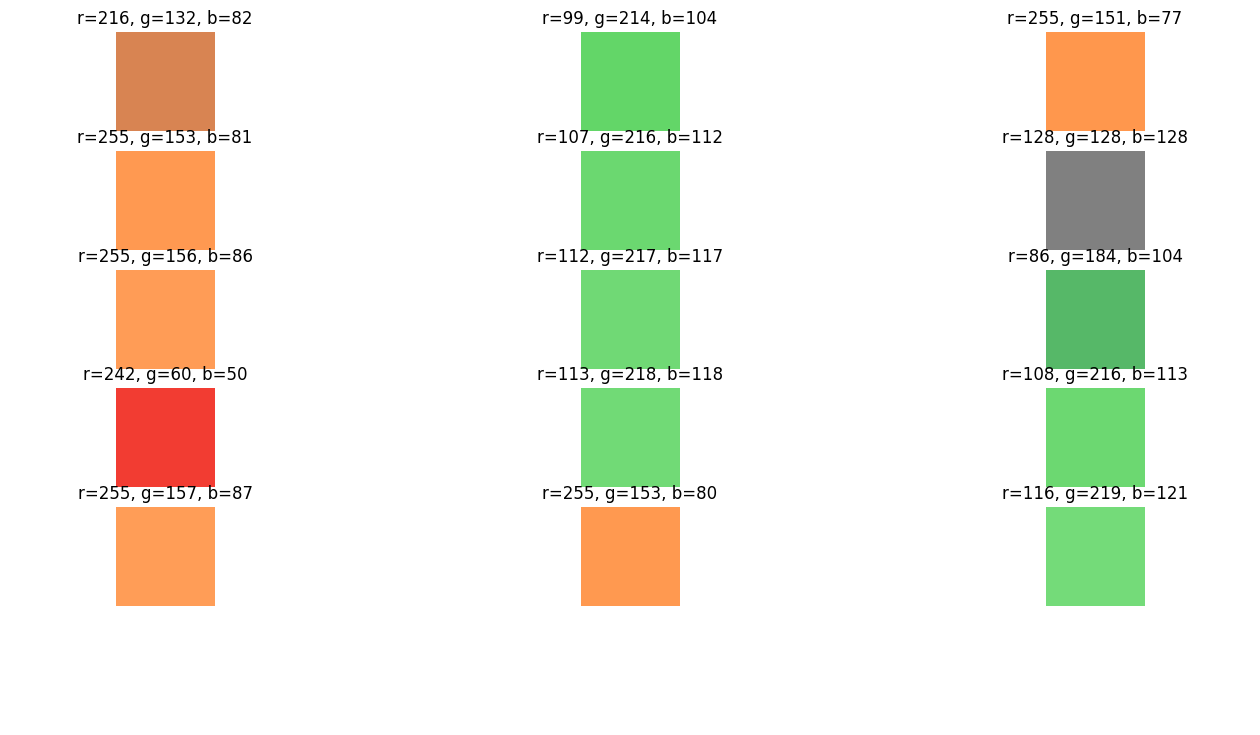

In [23]:
fig, axd = plt.subplot_mosaic(
    mosaic, gridspec_kw={"width_ratios": [1, 1, 1], "wspace": 0.5}, figsize=(16, 9)
)
assert number_of_colors < len(
    fig.axes
), "Increase the number of axis {len(fig.axes)} to at least {number_of_colors=}"
for ax in fig.axes:
    ax.set_axis_off()
for idx, (color, ax) in enumerate(
    zip(unique_colors, fig.axes)
):
    parts = " ".join(color.split()).split(" ")
    numbers = re.findall(r"\d+", color)
    # print (numbers[0], numbers[1], numbers[2])
    r = int(numbers[0])
    g = int(numbers[1])
    b = int(numbers[2])
    if idx < number_of_colors:
        ax.imshow([[(r, g, b)]])
        ax.set_title(f"{r=}, {g=}, {b=}")

# Analyse/resample the data and make plot

In [24]:
df = df.sort_values(by="timestamp").reset_index(drop=True).copy()

In [25]:
df["street"].shape

(39,)

In [26]:
df["street"].value_counts()

street
tiensestraat    39
Name: count, dtype: int64

In [27]:
df_resampled = df.query(f"(street == '{STREET}')").set_index("timestamp").resample("1Min").ffill()

In [28]:
df_resampled["street"].value_counts()

street
tiensestraat    385
Name: count, dtype: int64

In [29]:
# Remove the first row from the dataframe
df_resampled = df_resampled.reset_index().iloc[1:].set_index("timestamp")
df_resampled.head()

,location,street,path,color_0,p0_red,p0_green,p0_blue,traffic_color_0,color_1,p1_red,...,color_32,p32_red,p32_green,p32_blue,traffic_color_32,color_33,p33_red,p33_green,p33_blue,traffic_color_33
timestamp,,,,,,,,,,,,,,,,,,,,,
2023-10-17 11:43:00,leuven,tiensestraat,shots/leuven_tiensestraat_20231017-114239.png,"[86, 184, 104]",86.0,184.0,104.0,grey,"[99, 214, 104]",99.0,...,"[128, 128, 128]",128.0,128.0,128.0,grey,"[128, 128, 128]",128.0,128.0,128.0,grey
2023-10-17 11:44:00,leuven,tiensestraat,shots/leuven_tiensestraat_20231017-114239.png,"[86, 184, 104]",86.0,184.0,104.0,grey,"[99, 214, 104]",99.0,...,"[128, 128, 128]",128.0,128.0,128.0,grey,"[128, 128, 128]",128.0,128.0,128.0,grey
2023-10-17 11:45:00,leuven,tiensestraat,shots/leuven_tiensestraat_20231017-114239.png,"[86, 184, 104]",86.0,184.0,104.0,grey,"[99, 214, 104]",99.0,...,"[128, 128, 128]",128.0,128.0,128.0,grey,"[128, 128, 128]",128.0,128.0,128.0,grey
2023-10-17 11:46:00,leuven,tiensestraat,shots/leuven_tiensestraat_20231017-114543.png,"[86, 184, 104]",86.0,184.0,104.0,grey,"[99, 214, 104]",99.0,...,"[128, 128, 128]",128.0,128.0,128.0,grey,"[128, 128, 128]",128.0,128.0,128.0,grey
2023-10-17 11:47:00,leuven,tiensestraat,shots/leuven_tiensestraat_20231017-114543.png,"[86, 184, 104]",86.0,184.0,104.0,grey,"[99, 214, 104]",99.0,...,"[128, 128, 128]",128.0,128.0,128.0,grey,"[128, 128, 128]",128.0,128.0,128.0,grey


## Analyse the STREET

In [30]:
df_resampled["street"].value_counts()

street
tiensestraat    385
Name: count, dtype: int64

In [31]:
df_street = df_resampled[df_resampled.index > "2023-10-17 15:29:00"]

In [32]:
df_street.shape

(158, 173)

In [33]:
df_street

,location,street,path,color_0,p0_red,p0_green,p0_blue,traffic_color_0,color_1,p1_red,...,color_32,p32_red,p32_green,p32_blue,traffic_color_32,color_33,p33_red,p33_green,p33_blue,traffic_color_33
timestamp,,,,,,,,,,,,,,,,,,,,,
2023-10-17 15:30:00,leuven,tiensestraat,shots/leuven_tiensestraat_20231017-125503.png,"[86, 184, 104]",86.0,184.0,104.0,grey,"[99, 214, 104]",99.0,...,"[128, 128, 128]",128.0,128.0,128.0,grey,"[128, 128, 128]",128.0,128.0,128.0,grey
2023-10-17 15:31:00,leuven,tiensestraat,shots/leuven_tiensestraat_20231017-125503.png,"[86, 184, 104]",86.0,184.0,104.0,grey,"[99, 214, 104]",99.0,...,"[128, 128, 128]",128.0,128.0,128.0,grey,"[128, 128, 128]",128.0,128.0,128.0,grey
2023-10-17 15:32:00,leuven,tiensestraat,shots/leuven_tiensestraat_20231017-125503.png,"[86, 184, 104]",86.0,184.0,104.0,grey,"[99, 214, 104]",99.0,...,"[128, 128, 128]",128.0,128.0,128.0,grey,"[128, 128, 128]",128.0,128.0,128.0,grey
2023-10-17 15:33:00,leuven,tiensestraat,shots/leuven_tiensestraat_20231017-125503.png,"[86, 184, 104]",86.0,184.0,104.0,grey,"[99, 214, 104]",99.0,...,"[128, 128, 128]",128.0,128.0,128.0,grey,"[128, 128, 128]",128.0,128.0,128.0,grey
2023-10-17 15:34:00,leuven,tiensestraat,shots/leuven_tiensestraat_20231017-125503.png,"[86, 184, 104]",86.0,184.0,104.0,grey,"[99, 214, 104]",99.0,...,"[128, 128, 128]",128.0,128.0,128.0,grey,"[128, 128, 128]",128.0,128.0,128.0,grey
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-17 18:03:00,leuven,tiensestraat,shots/leuven_tiensestraat_20231017-180213.png,"[86, 184, 104]",86.0,184.0,104.0,grey,"[99, 214, 104]",99.0,...,"[128, 128, 128]",128.0,128.0,128.0,grey,"[128, 128, 128]",128.0,128.0,128.0,grey
2023-10-17 18:04:00,leuven,tiensestraat,shots/leuven_tiensestraat_20231017-180213.png,"[86, 184, 104]",86.0,184.0,104.0,grey,"[99, 214, 104]",99.0,...,"[128, 128, 128]",128.0,128.0,128.0,grey,"[128, 128, 128]",128.0,128.0,128.0,grey
2023-10-17 18:05:00,leuven,tiensestraat,shots/leuven_tiensestraat_20231017-180213.png,"[86, 184, 104]",86.0,184.0,104.0,grey,"[99, 214, 104]",99.0,...,"[128, 128, 128]",128.0,128.0,128.0,grey,"[128, 128, 128]",128.0,128.0,128.0,grey


### Plot trafic density with matplotlib

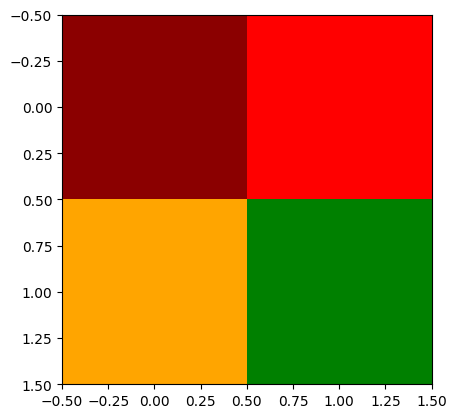

In [34]:
from matplotlib.colors import LinearSegmentedColormap

colors = ["darkred", "red", "orange", "green"]
cmap = LinearSegmentedColormap.from_list("my_cmap", colors)

plt.imshow([[0, 1], [2, 3]], cmap=cmap)
plt.show()

In [35]:
df_street.shape

(158, 173)

In [36]:
number_of_points = len(config[LOCATION][STREET]["points"][POINTS_LIST_NAME]) 
color_columns = [f"traffic_color_{i}" for i in range(number_of_points)]
color2index = {"darkred": 0, "red": 1, "orange": 2, "green": 3}
index_columns = []
df_matrix = df_street.copy()
for idx, colom in enumerate(color_columns):
    df_matrix.loc[:, f"index_color_{idx}"] = df_street[colom].map(color2index).values
    index_columns.append(f"index_color_{idx}")
traffic_color_matrix = df_matrix[index_columns].fillna(3).to_numpy()
traffic_color_matrix

array([[3., 3., 3., ..., 3., 3., 3.],
       [3., 3., 3., ..., 3., 3., 3.],
       [3., 3., 3., ..., 3., 3., 3.],
       ...,
       [3., 3., 3., ..., 2., 3., 3.],
       [3., 3., 3., ..., 2., 3., 3.],
       [3., 3., 3., ..., 2., 3., 3.]])

In [37]:
traffic_color_matrix.shape

(158, 18)

In [38]:
from matplotlib.text import Text
import matplotlib.dates as mdates

In [39]:
time = df_street.index

In [40]:
traffic_color_matrix.shape

(158, 18)

/var/folders/l3/cl401yld1x3f35c0g3sbm3b80000gp/T/ipykernel_7980/3211773135.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xlabels)


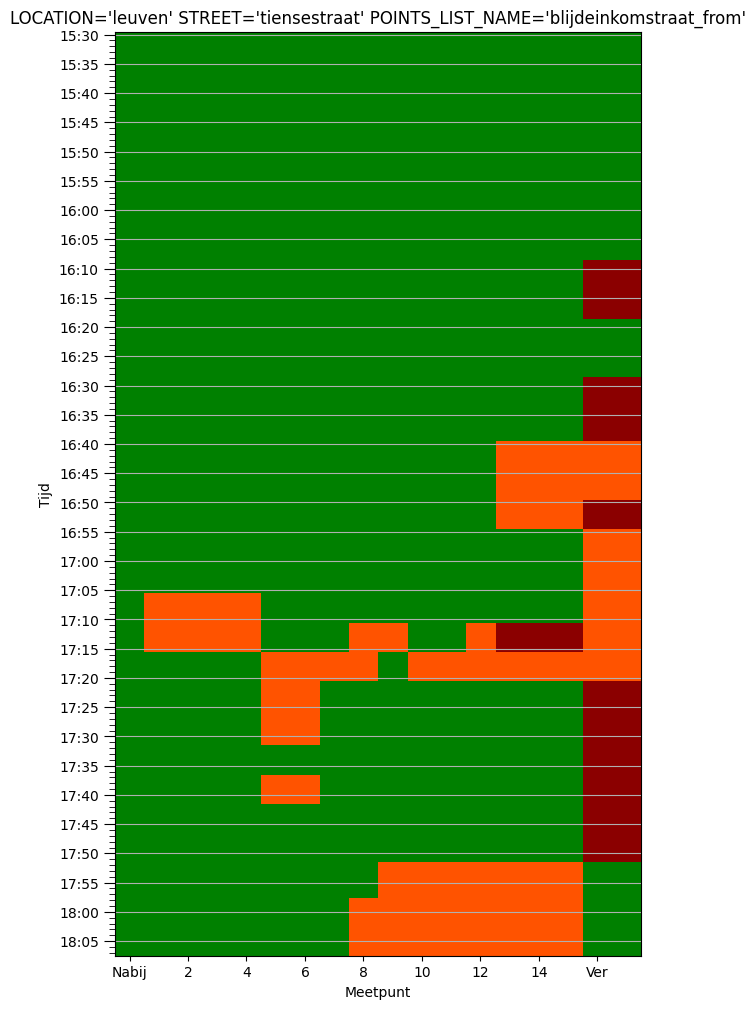

In [41]:
fig, ax = plt.subplots(figsize=(16, 12))

ax.set_xlabel("Meetpunt")
ax.set_ylabel("Tijd")

ticks = df_street.index
tick_labels = [
    f"{tick:%H:%M}" if idx % 5 == 0 else "" for idx, tick in enumerate(ticks)
]
major_tick_labels = [f"{tick:%H:%M}" for idx, tick in enumerate(ticks) if idx % 5 == 0]

# Plot the matrix using imshow on the specified axis
ax.imshow(traffic_color_matrix, cmap=cmap, aspect=0.2)

# Set y-axis tick locations and labels
ax.set_yticks(list(range(df_street.shape[0])), minor=True)
ax.set_yticks(list(range(0, df_street.shape[0], 5)), minor=False)
ax.set_yticklabels(major_tick_labels, minor=False)

# Customize tick parameters to make major ticks longer
ax.tick_params(axis="y", which="major", size=8)  # Adjust the size as needed
ax.tick_params(axis="y", which="minor", size=4)

# Add gridlines for the y-axis at major y-tick positions
ax.yaxis.grid(True, which="major")

# Hide gridlines for the x-axis
ax.xaxis.grid(False)

xlabels = ax.get_xticklabels()
for idx, label in enumerate(xlabels):
    # xlabels[idx].set_text('')
    if idx == 1:
        xlabels[1].set_text("Nabij")
    if idx == len(xlabels) - 1:
        xlabels[-2].set_text("Ver")
ax.set_xticklabels(xlabels)
ax.set_title(f"{LOCATION=} {STREET=} {POINTS_LIST_NAME=}")


plt.savefig(
    f"figs/{LOCATION}_{STREET}_231017_16u_18u_{POINTS_LIST_NAME}.png",  # Set path and filename
    dpi=300,  # Set dots per inch
    bbox_inches="tight",  # Remove extra whitespace around plot
    facecolor="white",
)  # Set background color to white